In [2]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

# from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp

from encoding_information.models.pixel_cnn import PixelCNN
import tensorflow as tf



2023-10-21 14:57:41.673973: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 14:57:42.258352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

In [9]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

seed = 0

training_hyperparams = dict(
    learning_rate = 1e-2,
    batch_size = 32,
    steps_per_epoch = 200,
    max_epochs = 25,
    patience = 25,
    num_val_samples = 1000
)

# architecture hyperparams
num_hidden_channels = 64
num_mixture_components = 40

pixel_cnn = PixelCNN(num_hidden_channels=num_hidden_channels, num_mixture_components=num_mixture_components)
val_loss_history = pixel_cnn.fit(train_images, **training_hyperparams)

Computing loss: 31it [00:00, 31.03it/s]


Initial validation NLL: 6.62


Epoch 1: 100%|██████████| 200/200 [00:07<00:00, 26.35it/s]
Computing loss: 31it [00:00, 165.34it/s]


Epoch 1: validation NLL: 1.70


Epoch 2: 100%|██████████| 200/200 [00:03<00:00, 53.75it/s]
Computing loss: 31it [00:00, 155.15it/s]


Epoch 2: validation NLL: 1.68


Epoch 3:  55%|█████▍    | 109/200 [00:02<00:01, 47.92it/s]


KeyboardInterrupt: 

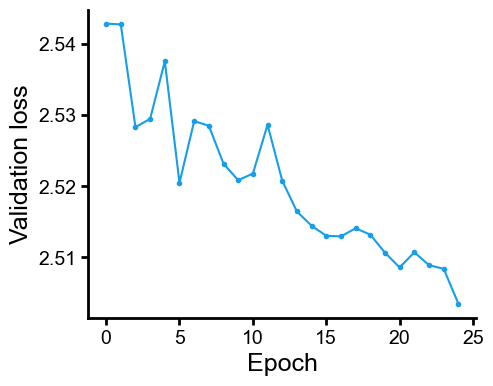

In [5]:
# Plot the loss history
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(val_loss_history[1:], '.-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
clear_spines(ax)
# ax.set(ylim=(1.4, 1.8))

In [6]:
pixel_cnn.compute_negative_log_likelihood(test_images[:500])

2023-10-21 15:00:46.643891: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-21 15:00:46.643930: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,28,28]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-21 15:00:50.824306: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-21 15:00:50.824335: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[15,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[15,64,28,28]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}),

2.4257494731801725

In [7]:
samples = pixel_cnn.generate_samples(4)

Generating samples:   0%|          | 0/28 [00:00<?, ?it/s]2023-10-21 15:00:56.300179: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-21 15:00:56.300209: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[4,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[4,64,28,28]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
Generating samples: 100%|██████████| 28/28 [03:11<00:00,  6.85s/it]


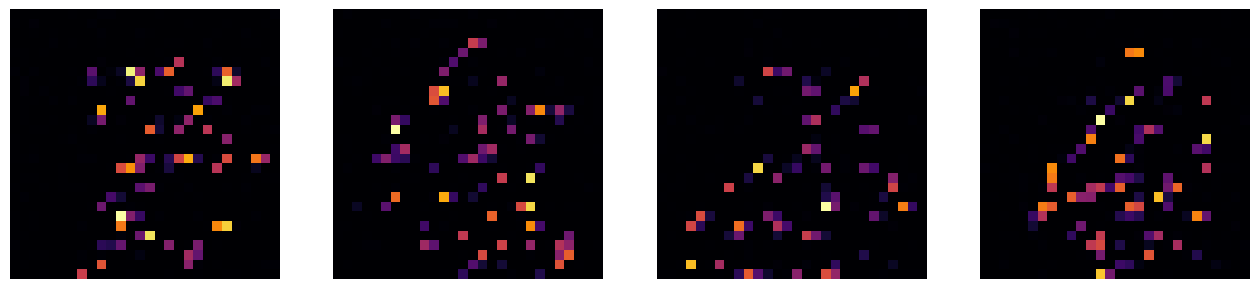

In [8]:
# Plot samples
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ax[i].imshow(samples[i], cmap='inferno')
    ax[i].axis('off')